In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

#from Cuda import DeviceDataLoader

In [2]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [3]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
IMAGE_CHANNELS = 1
RANK = 100
H_DIM = 200 

In [4]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [5]:
train_ds, val_ds = random_split(dataset, [50000, 10000])


In [6]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
#train_loader = DeviceDataLoader(train_loader, device)
#val_loader = DataLoader(val_ds, BATCH_SIZE)

In [7]:
model = VAE_CP_L3(IMAGE_SIZE*IMAGE_SIZE, H_DIM, Z_DIM, RANK).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#model = DeviceDataLoader(model, device)


In [8]:
model.decoder[0].layer_U1.weight.shape



torch.Size([100, 200])

In [9]:
list_of_losses = []
list_of_epochs =[]
for epoch in range(NUM_EPOCHS):
    for images, _ in train_loader: 
        images = images.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)   
        recon_images, mu, logvar = model(images.to(device))
        loss, bce, kld = loss_fn(recon_images.to(device), images.to(device), mu.to(device), logvar.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                #epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)
    #list_of_losses.append(loss[0])
    #list_of_epochs.append(epoch)_
    print('loss', loss)
    print("Epoch : ", epoch)

/home/ashish/Softwares/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss tensor(1961.5537, grad_fn=<AddBackward0>)
Epoch :  0
loss tensor(1458.8369, grad_fn=<AddBackward0>)
Epoch :  1
loss tensor(1415.5443, grad_fn=<AddBackward0>)
Epoch :  2
loss tensor(1310.4988, grad_fn=<AddBackward0>)
Epoch :  3
loss tensor(1410.6219, grad_fn=<AddBackward0>)
Epoch :  4


my_dict = {
    "epochs": list_of_epochs, 
    "learning_rate": [LEARNING_RATE] * len(list_of_epochs)
}

df = pd.DataFrame(my_dict)

In [10]:
for images, _ in train_loader: 
    recon_images, mu, logvar = model(images.to(device))
    break

In [11]:
recon_images = recon_images.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

In [12]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

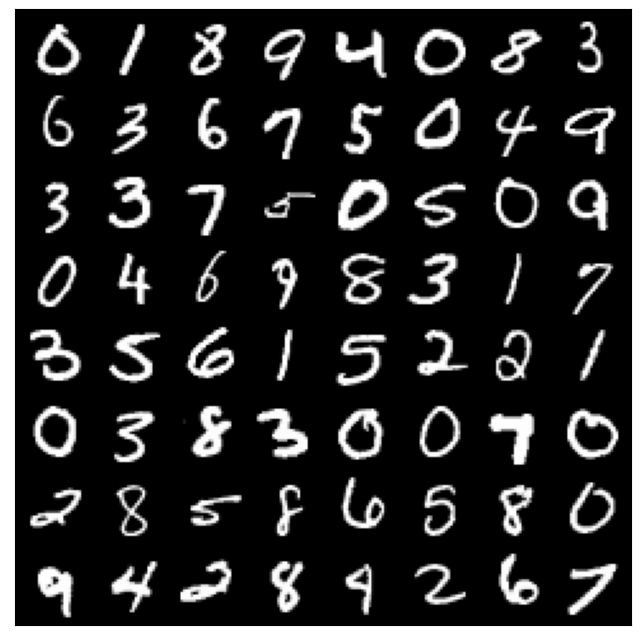

In [13]:
show_images(images)

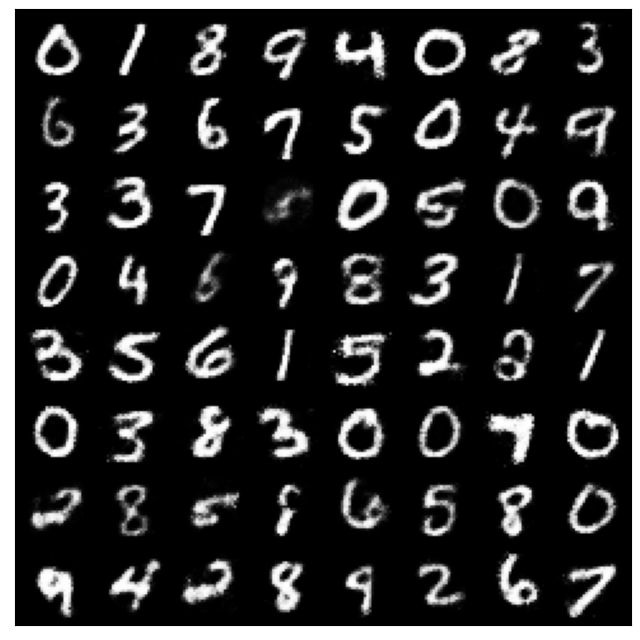

In [14]:
show_images(recon_images)

In [34]:
from poly_GAN import Generator_CP_L3, Critic_CP_L3, Generator_NCP_L3, Generator_CP_C3, gradient_penalty, gradient_penalty_C, initialize_weights
import torch.optim as optim
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

In [44]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
GEN_Z_DIM = 10
NUM_EPOCHS = 5
FEATURES_DISC = 28
FEATURES_GEN = 28
CRITIC_ITERATIONS = 1
#WEIGHT_CLIP = 0.01
LAMBDA_GP = 10
RANK_CRITIC = 50
RANK_GEN = 100
LHP = 300

In [17]:
latent_vectors = []
for images, _ in train_loader: 
    h = model.encoder(images)
    z, mu, logvar = model.bottleneck(h)
    z = z.reshape(z.shape[0], z.shape[1], 1, 1)
    latent_vectors.append(z)
    
   

In [36]:
latent = torch.cat(latent_vectors, 0)
latent = latent[:10000]

In [37]:
#latent = torch.cat(latent_vectors, 0)
dataset = TensorDataset(latent)
train_dl = DataLoader(latent, BATCH_SIZE, shuffle=True, num_workers=0)

In [45]:
gen = Generator_CP_C3(GEN_Z_DIM, Z_DIM, RANK_GEN).to(device)
critic = Critic_CP_L3(Z_DIM, RANK_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [20]:
noise = torch.randn((2, Z_DIM, 1, 1))
out = gen(noise)

In [46]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [47]:
for epoch in range(NUM_EPOCHS):
    for  real in tqdm(train_dl):
        #real = real.reshape(-1, IMAGE_SIZE*IMAGE_SIZE) 
        real = real.to(device)


        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((real.shape[0], GEN_Z_DIM, 1, 1)).to(device)
            #noise_C3 = torch.randn((real.shape[0], Z_DIM, 1, 1)).to(device)
            fake = gen(noise)
            #fake_C3 = gen(noise_C3)
            #fake = fake_C3.reshape(-1, IMAGE_SIZE*IMAGE_SIZE) 
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty_C(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            #for p in critic.parameters():
                #p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        ### Train Generator: min -E[critic(gen_fake)]
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()


    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]  \ Loss D: {loss_critic: .4f}, loss G: {loss_gen: .4f}")

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/5]  \ Loss D: -6.1227, loss G:  0.0473


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/5]  \ Loss D: -14.7658, loss G: -0.1447


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/5]  \ Loss D: -17.4521, loss G: -0.4680


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/5]  \ Loss D: -8.9527, loss G: -1.5359


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/5]  \ Loss D: -14.0534, loss G: -2.9995


In [48]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [50]:
input = torch.randn(64, GEN_Z_DIM, 1, 1).to(device)
latent_gen = gen(input)
#fake = fake.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE).to('cpu')
#show_images(fake)

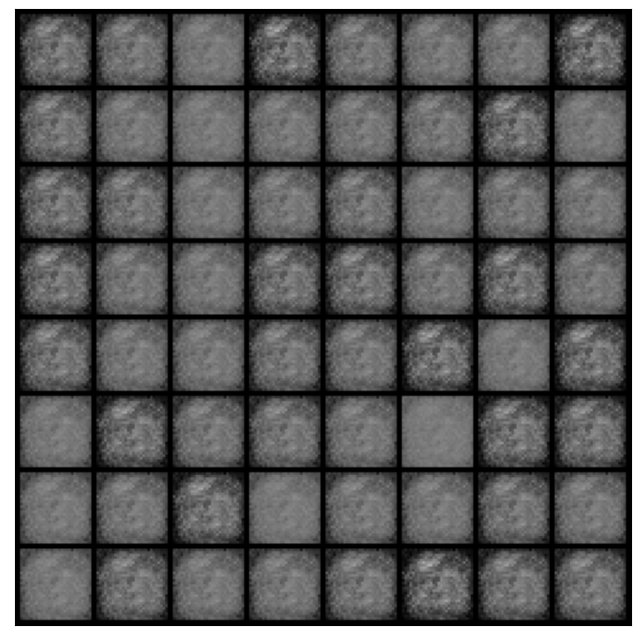

In [56]:
#input = torch.randn(3, Z_DIM, 1, 1).to(device)
latent_gen = gen(input).to('cpu')
latent_gen = latent_gen.view(latent_gen.shape[0], latent_gen.shape[1])
generated_image = model.decoder(model.fc3(latent_gen)).to('cpu')
generated_image = generated_image.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)
show_images(generated_image.to('cpu'))